# This notebook trains and compares three different U-Net models for segmentation tasks:

- U-Net: A classic U-Net architecture for image segmentation.
- Attention U-Net: A U-Net model with an attention mechanism integrated into the architecture, which helps the model focus on relevant regions for better segmentation results.
- Residual Attention U-Net: A U-Net model with both attention mechanism and residual connections. The attention mechanism helps the model focus on important regions, while residual connections improve the flow of information between layers and help the model learn deeper features.
## The following configurations are used for model training:
- Image dimensions and channels are determined based on the input data.
- A batch size of 8 is used for training.
- Adam optimizer with a learning rate of 1e-2 is used for optimization.
- Binary focal loss is used as the primary loss function.
- Dice coefficient is used as a metric for evaluation.
## The training process includes the following callbacks:
- ModelCheckpoint callback: Saves the best model based on the highest validation dice coefficient.
- EarlyStopping callback: Stops training if the validation loss doesn't improve for three consecutive epochs.
- CSVLogger callback: Saves the training history to a CSV file.
- Each model is trained for 20 epochs, and the execution time is calculated and printed for each model. The performance of the three models is compared, and the best performing model is selected based on the results.

# Create mask data

- This code reads train and test CSV files, creates full paths for image files, and defines functions to convert between masks and run-length encoding (RLE) format. It then iterates through the training dataset, creating mask images for each entry using the provided RLE data.

In [ ]:
import tensorflow as tf
import glob
import cv2
import os,gc
import numpy as np
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from PIL import Image
import tifffile as tiff
import os
from skimage.io import imread, imshow,imsave
from skimage.transform import resize
from tqdm import tqdm
import pathlib
import pandas as pd
import segmentation_models as sm
import random
import albumentations as A 
from tqdm import tqdm 

# Set the paths for images, masks, and test images
images_path='/Users/yunjaewon/tensorflow/HuBMAP/hubmap-organ-segmentation/train_images/'
masks_path='/Users/yunjaewon/tensorflow/HuBMAP/masks/'
test_img_path='/Users/yunjaewon/tensorflow/HuBMAP/hubmap-organ-segmentation/test_images/'

# Set the path for the internal dataset
INTERNAL_DATASET = pathlib.Path('/Users/yunjaewon/tensorflow/HuBMAP/hubmap-organ-segmentation')

# Read the train and test CSV files
train_df = pd.read_csv(INTERNAL_DATASET / 'train.csv')
test_df = pd.read_csv(INTERNAL_DATASET / 'test.csv')

# Add a column to the dataframes with the full path to the image files
train_df['image_filename'] = train_df['id'].apply(lambda x:  str(INTERNAL_DATASET) + '/' + 'train_images/' + str(x) + '.tiff')
test_df['image_filename'] = test_df['id'].apply(lambda x:  str(INTERNAL_DATASET) + '/' + 'test_images/' + str(x) + '.tiff')

# Function to convert mask to run-length encoding (RLE) format
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to convert RLE to mask
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Iterate through the train dataframe and create mask images for each entry
for i,id_ in tqdm(enumerate(train_df.id), total=len(train_df)):
    tiff.imwrite('masks/' + str(id_) + ".tiff", rle2mask(train_df.rle[i],
                                                         shape=(train_df.img_height[i],train_df.img_width[i])))

    

In [ ]:
aug_img_list=sorted(os.listdir(img_aug_path))
raw_img_list=sorted(os.listdir(images_path))
aug_msk_list=sorted(os.listdir(msk_aug_path))
raw_msk_list=sorted(os.listdir(masks_path))
number=random.randint(0,351)
print(number)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("augmented")
imshow(img_aug_path+'/'+aug_img_list[number])
plt.subplot(2,2,2)
plt.title("raw")
imshow(images_path+'/'+raw_img_list[number])
plt.subplot(2,2,3)
plt.title("augmented")
imshow(msk_aug_path+'/'+aug_msk_list[number])
plt.subplot(2,2,4)
plt.title("raw")
imshow(masks_path+'/'+raw_msk_list[number])
#test if the pixel value is correct for mask
print('aug', np.unique(imread(msk_aug_path+'/'+aug_msk_list[number])))
print('raw', np.unique(imread(masks_path+'/'+raw_msk_list[number]))) 


# Preprocess data
- This code reads and resizes the training images and masks, and stores them in X_train and Y_train respectively. It then selects a random image and mask to visualize. Finally, it splits the data into training and testing sets and prints the shapes of these datasets.

In [1]:
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from PIL import Image
import random
import tifffile as tiff
import os
from skimage.io import imread, imshow,imsave
from skimage.transform import resize
import albumentations as A 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

In [2]:
images_path='/Users/yunjaewon/tensorflow/HuBMAP/hubmap-organ-segmentation/train_images'
masks_path='/Users/yunjaewon/tensorflow/HuBMAP/masks'
test_img_path='/Users/yunjaewon/tensorflow/HuBMAP/hubmap-organ-segmentation/test_images'

In [3]:
# Set the size of the images and masks
SIZE = 256

# Initialize the list for training images
X_train = []

# Read and resize training images
images = sorted(os.listdir(images_path))
for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.split('.')[1] == 'tiff':
        image = cv2.imread(os.path.join(images_path, image_name), 1)
        image = resize(image, (SIZE, SIZE), mode='edge', anti_aliasing=False, 
                       preserve_range=True, order=0)
        X_train.append(np.array(image, dtype='uint8'))

X_train = np.array(X_train)
print(X_train.min(), X_train.max())

# Initialize the list for training masks
Y_train = []

# Read and resize training masks
masks = sorted(os.listdir(masks_path))
for i, mask_name in tqdm(enumerate(masks), total=len(masks)):
    if mask_name.split('.')[1] == 'tiff':
        mask = cv2.imread(os.path.join(masks_path, mask_name), 0)
        mask = resize(mask, (SIZE, SIZE), mode='edge', anti_aliasing=False,
                      preserve_range=True, order=0)
        Y_train.append(np.array(mask))

Y_train = np.array(Y_train, dtype='uint8')
Y_train = np.expand_dims(Y_train, axis=3)



100%|█████████████████████████████████████████| 351/351 [00:40<00:00,  8.66it/s]


0 255


100%|█████████████████████████████████████████| 352/352 [00:13<00:00, 25.69it/s]


/Users/yunjaewon/tensorflow/env/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


X_test shape (36, 256, 256, 3)
Y_test shape (36, 256, 256, 1)
X_train shape (315, 256, 256, 3)
Y_train shape (315, 256, 256, 1)


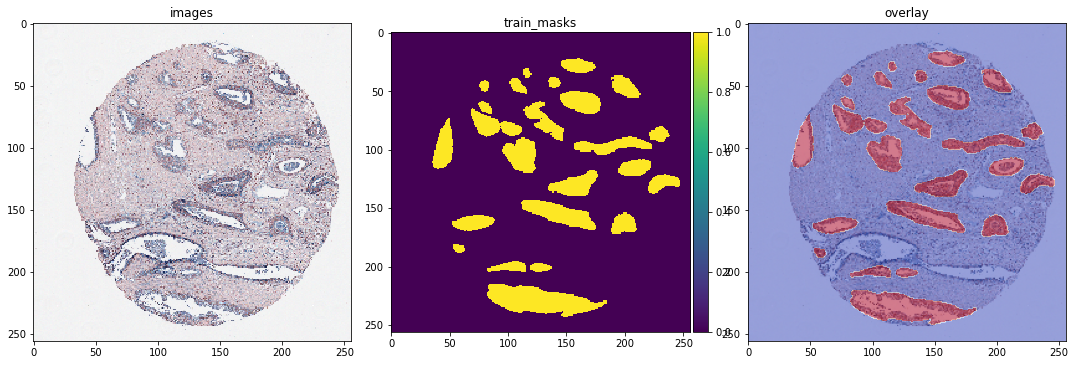

In [4]:
# Select a random image and mask, and visualize them
number = random.randint(0, len(X_train))
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("images")
imshow(X_train[number])
plt.subplot(1, 3, 2)
plt.title("train_masks")
imshow(Y_train[number])
plt.subplot(1, 3, 3)
plt.title("overlay")
plt.imshow(X_train[number])
plt.imshow(Y_train[number], cmap='coolwarm', alpha=0.5)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

# Print the shapes of the datasets
print('X_test shape', X_test.shape)
print('Y_test shape', Y_test.shape)
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)


# Unet vs Attention Unet vs Residual Attention Unet

## Define base blocks

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers



In [6]:
# Dice coefficient metric
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


# Dice coefficient loss
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)




# Convolution block for the U-Net architecture
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    # Two convolution layers followed by an optional batch normalization and dropout
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

# Function to repeat tensor elements
def repeat_elem(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

# Residual convolution block for the U-Net architecture
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    # Two convolution layers with an optional batch normalization and dropout
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    # Shortcut connection
    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    # Add shortcut connection and apply activation
    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path

# Gating signal for the attention mechanism
def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    # Get the shapes of the input tensors
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Resize x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    # Resize gating signal to have the same number of filters as inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    
    # Upsample gating signal to match the shape of theta_x
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                        padding='same')(phi_g)

    # Element-wise addition of upsampled gating signal and resized x signal
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    
    # Compute attention coefficients
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    
    # Upsample attention coefficients to match the shape of x
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    # Repeat attention coefficients to match the number of channels in x
    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    # Apply attention coefficients to x signal
    y = layers.multiply([upsample_psi, x])

    # Output attention block with the same number of channels as x
    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



In [7]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    U-Net architecture for image segmentation.
    
    Args:
        input_shape (tuple): Input shape for the model, e.g., (256, 256, 3) for a 256x256 RGB image.
        NUM_CLASSES (int): Number of output classes, default is 1 for binary segmentation.
        dropout_rate (float): Dropout rate to be applied after each pair of convolution layers, default is 0.0.
        batch_norm (bool): Whether to use batch normalization, default is True.
        
    Returns:
        model (tf.keras.Model): U-Net model with the specified configuration.
    '''
    # Network structure parameters
    FILTER_NUM = 64  # Number of filters for the first layer
    FILTER_SIZE = 3  # Size of the convolutional filter
    UP_SAMP_SIZE = 2  # Size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1: Convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)
    
    # DownRes 2: Convolution + pooling
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)
    
    # DownRes 3: Convolution + pooling
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)
    
    # DownRes 4: Convolution + pooling
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)
    
    # DownRes 5: Convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6: Upsampling + concatenation + convolution
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    
    # UpRes 7: Upsampling + concatenation + convolution
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    
    
    # UpRes 8: Upsampling + concatenation + convolution
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    
    # UpRes 9: Upsampling + concatenation + convolution
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # Final 1x1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    return model


In [8]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # Network structure
    FILTER_NUM = 64 # Number of basic filters for the first layer
    FILTER_SIZE = 3 # Size of the convolutional filter
    UP_SAMP_SIZE = 2 # Size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1: Convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)
    
    # DownRes 2: Convolution + pooling
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)
    
    # DownRes 3: Convolution + pooling
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)
    
    # DownRes 4: Convolution + pooling
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)
    
    # DownRes 5: Convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6: Attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8 * FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8 * FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    
    # UpRes 7: Attention gated concatenation + upsampling + double residual convolution
    gating_32 = gating_signal(up_conv_16, 4 * FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4 * FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    
    # UpRes 8: Attention gated concatenation + upsampling + double residual convolution
    gating_64 = gating_signal(up_conv_32, 2 * FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2 * FILTER_NUM)
        
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    
    # UpRes 9: Attention gated concatenation + upsampling + double residual convolution
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1x1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model



In [9]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention Residual U-Net (Attention ResUNet)
    Combines residual connections and attention mechanisms within the U-Net architecture.
    '''
    # Network structure
    FILTER_NUM = 64  # Number of basic filters for the first layer
    FILTER_SIZE = 3  # Size of the convolutional filter
    UP_SAMP_SIZE = 2  # Size of upsampling filters

    # Input data
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3  # Dimension of the image depth (channels)

    # Downsampling layers
    # DownRes 1: Double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)
    # DownRes 5: Residual convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16 * FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6: Attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8 * FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8 * FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8 * FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4 * FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4 * FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4 * FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2 * FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2 * FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2 * FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1x1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  # Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


    

## Train Unet vs Attention Unet vs Attention residual unet

### Unet

In [11]:
from focal_loss import BinaryFocalLoss
# Model Parameters
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  # Binary
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
batch_size = 8



# UNet Model
'''
UNet
'''
# Add Callbacks: ModelCheckpoint, EarlyStopping, CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# ModelCheckpoint callback saves a model at some interval.
filepath = "saved_models/custom_unet_no_aug-{epoch:02d}-{val_dice_coef:.2f}.hdf5"  # File name includes epoch and validation accuracy.
# Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

# EarlyStopping callback stops the training when there is no improvement in the validation loss for three consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# CSVLogger callback saves the training history as a CSV file.
csv_logger = CSVLogger('unet_training_history_20epochs.csv')

callbacks_list = [checkpoint, early_stop, csv_logger]

unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr=1e-2), loss=BinaryFocalLoss(gamma=2),
                   metrics=dice_coef)

start1 = datetime.now()
unet_history = unet_model.fit(X_train, Y_train,
                              verbose=1,
                              batch_size=batch_size,
                              validation_data=(X_test, Y_test),
                              callbacks=callbacks_list,
                              shuffle=False,
                              epochs=20)

stop1 = datetime.now()
# Execution time of the model
execution_time_Unet = stop1 - start1
print("UNet execution time is: ", execution_time_Unet)

unet_model.save('UNet_20epochs_B_focal.hdf5')


Epoch 1/20


2023-04-04 11:17:26.901937: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-04 11:17:28.454353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.1694 - dice_coef: 0.1763

2023-04-04 11:18:15.084886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_dice_coef improved from -inf to 0.17555, saving model to saved_models/custom_unet_no_aug-01-0.18.hdf5
40/40 [==============================] - 50s 1s/step - loss: 0.1694 - dice_coef: 0.1763 - val_loss: 14.5645 - val_dice_coef: 0.1756
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.1090 - dice_coef: 0.1819
Epoch 2: val_dice_coef did not improve from 0.17555
40/40 [==============================] - 47s 1s/step - loss: 0.1090 - dice_coef: 0.1819 - val_loss: 1.5536 - val_dice_coef: 2.5423e-05
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.0806 - dice_coef: 0.1821
Epoch 3: val_dice_coef did not improve from 0.17555
40/40 [==============================] - 48s 1s/step - loss: 0.0806 - dice_coef: 0.1821 - val_loss: 1.7515 - val_dice_coef: 0.0024
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.0716 - dice_coef: 0.1900
Epoch 4: val_dice_coef did not improve from 0.17555
40/40 [==============================] - 47s 

### Attention Unet

In [12]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
from focal_loss import BinaryFocalLoss
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Parameters
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  # Binary
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
batch_size = 8

# ModelCheckpoint callback saves a model at some interval.
filepath = "saved_models/custom_attention_unet_no_aug-{epoch:02d}-{val_dice_coef:.2f}.hdf5"  # File name includes epoch and validation accuracy.
# Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

# EarlyStopping callback stops the training when there is no improvement in the validation loss for three consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# CSVLogger callback saves the training history as a CSV file.
csv_logger = CSVLogger('attunet_training_history_20epochs.csv')

callbacks_list = [checkpoint, early_stop, csv_logger]


'''
Attention UNet
'''
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr=1e-2), loss=BinaryFocalLoss(gamma=2),
                       metrics=dice_coef)

print(att_unet_model.summary())

start2 = datetime.now()
att_unet_history = att_unet_model.fit(X_train, Y_train,
                                      verbose=1,
                                      batch_size=batch_size,
                                      validation_data=(X_test, Y_test),
                                      callbacks=callbacks_list,
                                      shuffle=False,
                                      epochs=20)

stop2 = datetime.now()
# Execution time of the model
execution_time_Att_Unet = stop2 - start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('Attention_UNet_20epochs_B_focal.hdf5')


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                    

                                                                                                  
 batch_normalization_46 (BatchN  (None, 16, 16, 1024  4096       ['conv2d_46[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_46 (Activation)     (None, 16, 16, 1024  0           ['batch_normalization_46[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 1024  9438208     ['activation_46[0][0]']          
                                )                                                                 
                                                                                                  
 batch_nor

 conv2d_56 (Conv2D)             (None, 32, 32, 256)  262400      ['activation_43[0][0]']          
                                                                                                  
 add_1 (Add)                    (None, 32, 32, 256)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'conv2d_56[0][0]']              
                                                                                                  
 activation_54 (Activation)     (None, 32, 32, 256)  0           ['add_1[0][0]']                  
                                                                                                  
 conv2d_58 (Conv2D)             (None, 32, 32, 1)    257         ['activation_54[0][0]']          
                                                                                                  
 activation_55 (Activation)     (None, 32, 32, 1)    0           ['conv2d_58[0][0]']              
          

 ormalization)                  8)                                                                
                                                                                                  
 concatenate_10 (Concatenate)   (None, 128, 128, 38  0           ['up_sampling2d_13[0][0]',       
                                4)                                'batch_normalization_57[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 128, 128, 12  442496      ['concatenate_10[0][0]']         
                                8)                                                                
                                                                                                  
 batch_normalization_58 (BatchN  (None, 128, 128, 12  512        ['conv2d_67[0][0]']              
 ormalization)                  8)                                                                
          

                                                                                                  
 batch_normalization_63 (BatchN  (None, 256, 256, 64  256        ['conv2d_75[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_67 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_63[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 1)  65          ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_64 (BatchN  (None, 256, 256, 1)  4          ['conv2d_76[0][0]']              
 ormalizat

2023-04-04 11:24:42.679975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.1968 - dice_coef: 0.1760

2023-04-04 11:25:39.691646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_dice_coef improved from -inf to 0.17555, saving model to saved_models/custom_attention_unet_no_aug-01-0.18.hdf5
40/40 [==============================] - 62s 1s/step - loss: 0.1968 - dice_coef: 0.1760 - val_loss: 14.5645 - val_dice_coef: 0.1756
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.1119 - dice_coef: 0.1824
Epoch 2: val_dice_coef improved from 0.17555 to 0.18335, saving model to saved_models/custom_attention_unet_no_aug-02-0.18.hdf5
40/40 [==============================] - 58s 1s/step - loss: 0.1119 - dice_coef: 0.1824 - val_loss: 12.8094 - val_dice_coef: 0.1834
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.0790 - dice_coef: 0.1817
Epoch 3: val_dice_coef did not improve from 0.18335
40/40 [==============================] - 57s 1s/step - loss: 0.0790 - dice_coef: 0.1817 - val_loss: 0.1924 - val_dice_coef: 0.1085
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.0714 - dice_coef: 0.1872
Epoch 4: val_d

### Attention Residual Unet

In [13]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
from focal_loss import BinaryFocalLoss
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger

# Model Parameters
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  # Binary
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
batch_size = 8

# ModelCheckpoint callback saves a model at some interval.
filepath = "saved_models/custom_att_res_unet_no_patch-{epoch:02d}-{val_dice_coef:.2f}.hdf5"  # File name includes epoch and validation accuracy.
# Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
# CSVLogger callback saves the training history as a CSV file.
csv_logger = CSVLogger('attreunet_training_history_20epochs.csv')
# EarlyStopping callback stops the training when there is no improvement in the validation loss for three consecutive epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
callbacks_list = [checkpoint, early_stop, csv_logger]


'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr=1e-2), loss=BinaryFocalLoss(gamma=2),
                           metrics=dice_coef)

print(att_res_unet_model.summary())

# Convert Y_train and Y_test to float32
Y_train = np.array(Y_train, dtype='float32')
Y_test = np.array(Y_test, dtype='float32')

start3 = datetime.now()
att_res_unet_history = att_res_unet_model.fit(X_train, Y_train,
                                              verbose=1,
                                              batch_size=batch_size,
                                              validation_data=(X_test, Y_test),
                                              shuffle=False,
                                              epochs=20)
stop3 = datetime.now()

# Execution time of the model
execution_time_AttResUnet = stop3 - start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

att_res_unet_model.save('AttResUnet_no_aug_20epochs_B_focal.hdf5')


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_65 (BatchN  (None, 256, 256, 64  256        ['conv2d_77[0][0]']              
 ormalization)                  )                                                  

 add_6 (Add)                    (None, 64, 64, 256)  0           ['batch_normalization_73[0][0]', 
                                                                  'batch_normalization_72[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 64, 64, 256)  0           ['add_6[0][0]']                  
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 32, 32, 256)  0          ['activation_74[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_86 (Conv2D)             (None, 32, 32, 512)  1180160     ['max_pooling2d_14[0][0]']       
                                                                                                  
 batch_nor

 up_sampling2d_16 (UpSampling2D  (None, 32, 32, 1)   0           ['activation_81[0][0]']          
 )                                                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 32, 32, 512)  0           ['up_sampling2d_16[0][0]']       
                                                                                                  
 multiply_4 (Multiply)          (None, 32, 32, 512)  0           ['lambda_4[0][0]',               
                                                                  'activation_76[0][0]']          
                                                                                                  
 conv2d_96 (Conv2D)             (None, 32, 32, 512)  262656      ['multiply_4[0][0]']             
                                                                                                  
 up_sampli

 conv2d_105 (Conv2D)            (None, 64, 64, 256)  1769728     ['concatenate_13[0][0]']         
                                                                                                  
 batch_normalization_87 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_105[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 64, 64, 256)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 conv2d_107 (Conv2D)            (None, 64, 64, 256)  196864      ['concatenate_13[0][0]']         
                                                                                                  
 conv2d_106 (Conv2D)            (None, 64, 64, 256)  590080      ['activation_87[0][0]']          
          

                                                                                                  
 batch_normalization_93 (BatchN  (None, 128, 128, 12  512        ['conv2d_114[0][0]']             
 ormalization)                  8)                                                                
                                                                                                  
 add_14 (Add)                   (None, 128, 128, 12  0           ['batch_normalization_94[0][0]', 
                                8)                                'batch_normalization_93[0][0]'] 
                                                                                                  
 activation_93 (Activation)     (None, 128, 128, 12  0           ['add_14[0][0]']                 
                                8)                                                                
                                                                                                  
 conv2d_11

 activation_98 (Activation)     (None, 256, 256, 64  0           ['add_16[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_124 (Conv2D)            (None, 256, 256, 1)  65          ['activation_98[0][0]']          
                                                                                                  
 batch_normalization_100 (Batch  (None, 256, 256, 1)  4          ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 256, 256, 1)  0           ['batch_normalization_100[0][0]']
                                                                                                  
Total para

2023-04-04 11:31:28.647207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.1968 - dice_coef: 0.1833

2023-04-04 11:32:35.064017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 73s 2s/step - loss: 0.1968 - dice_coef: 0.1833 - val_loss: 14.5645 - val_dice_coef: 0.1756
Epoch 2/20
40/40 [==============================] - 64s 2s/step - loss: 0.1046 - dice_coef: 0.1889 - val_loss: 14.5645 - val_dice_coef: 0.1756
Epoch 3/20
40/40 [==============================] - 64s 2s/step - loss: 0.0791 - dice_coef: 0.1926 - val_loss: 14.5501 - val_dice_coef: 0.1756
Epoch 4/20
40/40 [==============================] - 64s 2s/step - loss: 0.0719 - dice_coef: 0.1881 - val_loss: 13.3230 - val_dice_coef: 0.1760
Epoch 5/20
40/40 [==============================] - 64s 2s/step - loss: 0.0690 - dice_coef: 0.1931 - val_loss: 4.4979 - val_dice_coef: 0.1796
Epoch 6/20
40/40 [==============================] - 65s 2s/step - loss: 0.0672 - dice_coef: 0.1993 - val_loss: 0.1272 - val_dice_coef: 0.1545
Epoch 7/20
40/40 [==============================] - 64s 2s/step - loss: 0.0668 - dice_coef: 0.2023 - val_loss: 0.2190 - val_dice_coef: 0.1563
Epoch 8/20
40

1/1 [==============================] - 0s 119ms/step


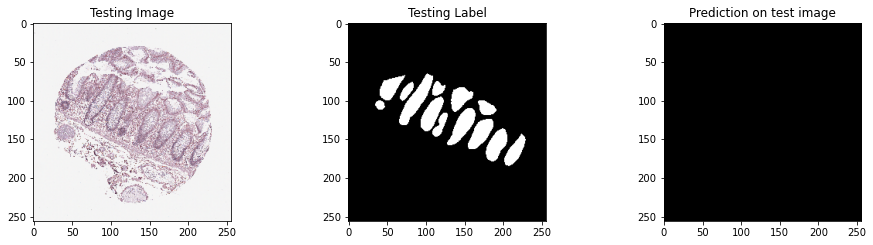

In [42]:
import random
model=att_res_unet_model
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)

plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

1/1 [==============================] - 0s 87ms/step


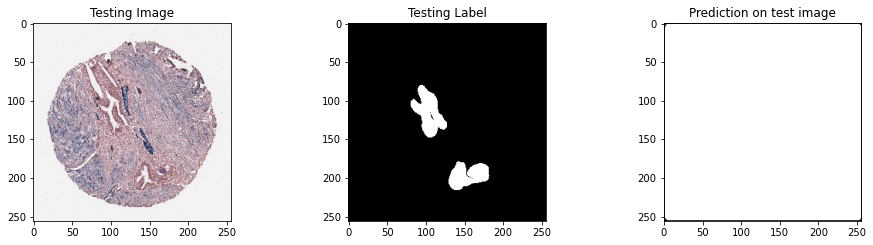

In [43]:
import random
model=unet_model

test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)

plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

1/1 [==============================] - 0s 100ms/step


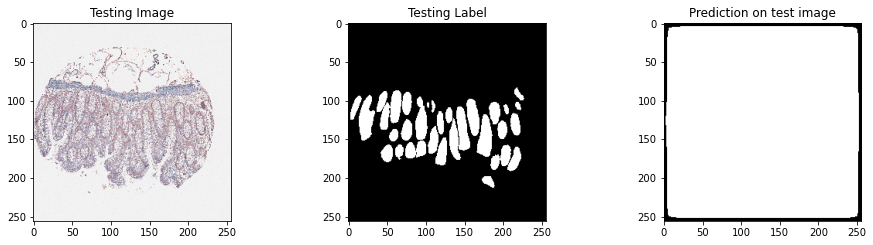

In [44]:
import random
model=att_unet_model

test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)

plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# Plot results 

This code will create two separate plots:

- The first plot will show the training loss and validation loss of the three models across the 20 epochs.
- The second plot will show the training dice coefficient and validation dice coefficient of the three models across the 20 epochs.
- Both plots make it easy to compare the performance of the three models.

ValueError: x and y must have same first dimension, but have shapes (9,) and (7,)

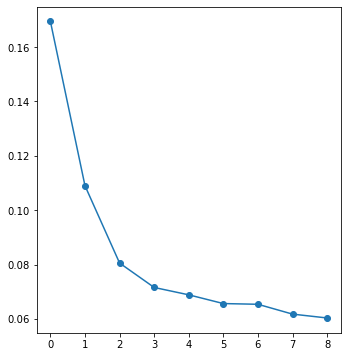

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
unet_history = pd.read_csv('/Users/yunjaewon/tensorflow/HuBMAP/unet_training_history_20epochs.csv')
attention_unet_history = pd.read_csv('/Users/yunjaewon/tensorflow/HuBMAP/attunet_training_history_20epochs.csv')
#residual_attention_unet_history = pd.read_csv('/Users/yunjaewon/tensorflow/HuBMAP/AttResUnet_no_aug_20epochs_B_focal.hdf5')

# Extract the metrics to compare
epoch = unet_history['epoch']
metrics = ['loss', 'val_loss', 'dice_coef', 'val_dice_coef']
labels = ['UNet', 'Attention UNet', 'Residual Attention UNet']

# Plot Losses
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics[:2]):
    plt.subplot(1, 2, i + 1)
    plt.plot(epoch, unet_history[metric], label=labels[0], marker='o')
    plt.plot(epoch, attention_unet_history[metric], label=labels[1], marker='o')
    #plt.plot(epoch, residual_attention_unet_history[metric], label=labels[2], marker='o')

    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.title(metric.capitalize() + ' Comparison')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.savefig('loss_comparison.png')
plt.show()

# Plot Dice Coefficients
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics[2:]):
    plt.subplot(1, 2, i + 1)
    plt.plot(epoch, unet_history[metric], label=labels[0], marker='o')
    plt.plot(epoch, attention_unet_history[metric], label=labels[1], marker='o')
    #plt.plot(epoch, residual_attention_unet_history[metric], label=labels[2], marker='o')

    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize().replace('_', ' '))
    plt.title(metric.capitalize().replace('_', ' ') + ' Comparison')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.savefig('dice_coefficient_comparison.png')
plt.show()
